# Probability Mass Functions

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## PMFs

Another way to represent a distribution is a **probability mass
function** (PMF), which maps from each value to its probability. A
**probability** is a frequency expressed as a fraction of the sample
size, `n`. To get from frequencies to probabilities, we divide through
by `n`, which is called **normalization**.

Given a Hist, we can make a dictionary that maps from each value to its
probability:

In [4]:
from thinkstats import Hist

hist = Hist.from_seq([1, 2, 2, 3, 5])
hist

,probs
1,1
2,2
3,1
5,1


<IPython.core.display.Javascript object>

In [5]:
n = hist.sum()
d = {}
for x, freq in hist.items():
    prob = freq / n
    print(x, prob)

1 0.2
2 0.4
3 0.2
5 0.2


<IPython.core.display.Javascript object>

Or we can use the `Pmf` class provided by `thinkstats2`. Like Hist, the
`Pmf` constructor can take a list, pandas `Series`, dictionary, Hist, or
another `Pmf` object. Here's an example with a simple list:

In [6]:
from empiricaldist import Pmf

pmf = Pmf.from_seq([1, 2, 2, 3, 5])
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


<IPython.core.display.Javascript object>

The `Pmf` is normalized so total probability is 1.

`Pmf` and `Hist` objects are similar in many ways; in fact, they inherit
many of their methods from a common parent class. For example, the
methods `values` and `items` work the same way for both. The biggest
difference is that a Hist maps from values to integer counters; a `Pmf`
maps from values to floating-point probabilities.

To look up the probability associated with a value, use parentheses to call the `Pmf` like a function.

In [7]:
pmf(2)

0.4

<IPython.core.display.Javascript object>

To assign a probability to a quantity, you have to use the bracket operator.

In [8]:
pmf[2] = 0.2
pmf(2)

0.2

<IPython.core.display.Javascript object>

You can modify an existing `Pmf` by incrementing the probability
associated with a value:

In [9]:
pmf[2] += 0.3
pmf(2)

0.5

<IPython.core.display.Javascript object>

Or you can multiply a probability by a factor:

In [10]:
pmf[2] *= 0.5
pmf(2)

0.25

<IPython.core.display.Javascript object>

If you modify a `Pmf`, the result may not be normalized; that is, the
probabilities may no longer add up to 1. To check, you can call `sum`,
which returns the sum of the probabilities:

In [11]:
pmf.sum()

0.8500000000000001

<IPython.core.display.Javascript object>

To renormalize, call `normalize`:

In [12]:
pmf.normalize()
pmf.sum()

1.0

<IPython.core.display.Javascript object>

`Pmf` objects provide a `copy` method so you can make and modify a copy
without affecting the original.

In [13]:
pmf.copy()

,probs
1,0.235294
2,0.294118
3,0.235294
5,0.235294


<IPython.core.display.Javascript object>

A note on notation: I use `Pmf` for the name of the class, `pmf` for an instance of
the class, and PMF for the mathematical concept of a probability mass
function.

## Plotting PMFs

There are two ways to plot a `pmf`:

-   To plot a `Pmf` as a bar graph, you can use `bar`. Bar
    graphs are most useful if the number of values in the `Pmf` is small.

-   To plot a `Pmf` as a step function, you can use `plot`. This
    option is most useful if there are a large number of values and the
    `Pmf` is smooth. This function also works with `Hist` objects.

The following figure shows PMFs of pregnancy length for first babies and others using bar graphs.

In [14]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [15]:
import nsfg

live, firsts, others = nsfg.make_frames()

<IPython.core.display.Javascript object>

In [16]:
first_pmf = Pmf.from_seq(firsts.prglngth, name="firsts")
other_pmf = Pmf.from_seq(others.prglngth, name="others")

<IPython.core.display.Javascript object>

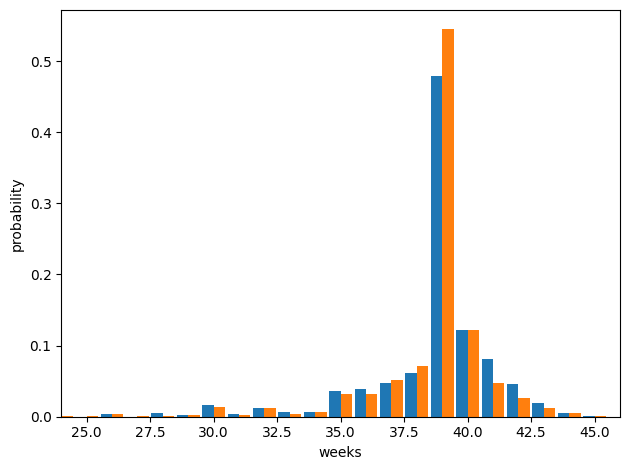

<IPython.core.display.Javascript object>

In [17]:
from thinkstats import two_bar_plots

two_bar_plots(first_pmf, other_pmf)
decorate(xlabel="weeks", ylabel="probability", xlim=[24, 46])

The following figure shows the same PMFs as step functions.

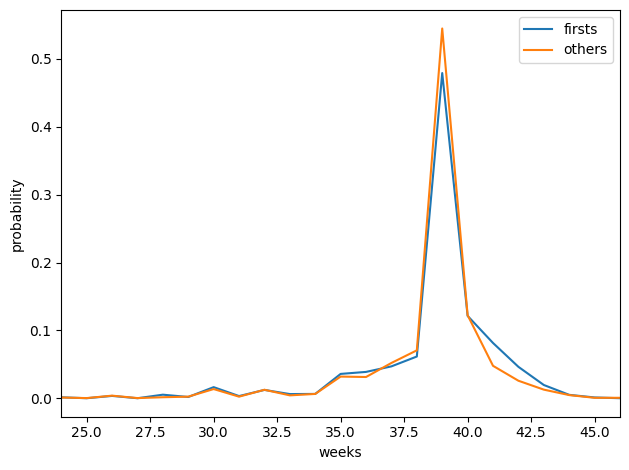

<IPython.core.display.Javascript object>

In [18]:
first_pmf.plot()
other_pmf.plot()
decorate(xlabel="weeks", ylabel="probability", xlim=[24, 46])

By plotting the PMF instead of the histogram, we can compare the two
distributions without being mislead by the difference in sample size.
Based on this figure, first babies seem to be less likely than others to
arrive on time (week 39) and more likely to be late (weeks 41 and 42).

## Other visualizations

Histograms and PMFs are useful while you are exploring data and trying
to identify patterns and relationships. Once you have an idea what is
going on, a good next step is to design a visualization that makes the
patterns you have identified as clear as possible.

In the NSFG data, the biggest differences in the distributions are near
the mode. So it makes sense to zoom in on that part of the graph, and to
transform the data to emphasize differences:

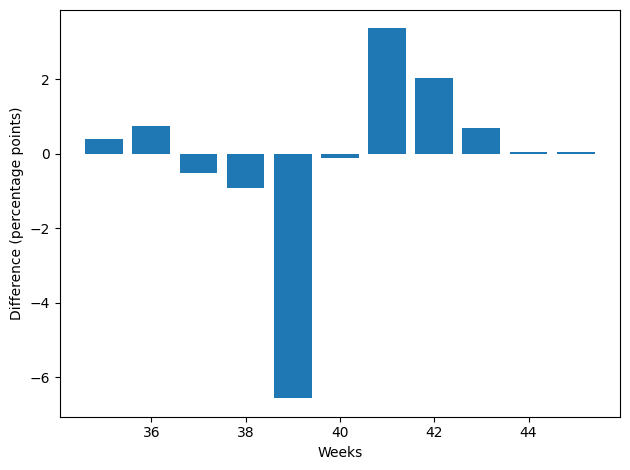

<IPython.core.display.Javascript object>

In [19]:
weeks = range(35, 46)
diffs = []
for week in weeks:
    p1 = first_pmf(week)
    p2 = other_pmf(week)
    diff = 100 * (p1 - p2)
    diffs.append(diff)

plt.bar(weeks, diffs)
decorate(xlabel="Weeks", ylabel="Difference (percentage points)")

In this code, `weeks` is the range of weeks; `diffs` is the difference
between the two PMFs in percentage points.
The following figure shows the result as a bar chart.
This figure makes the pattern clearer: first babies are less likely to
be born in week 39, and somewhat more likely to be born in weeks 41 and
42.

For now we should hold this conclusion only tentatively. We used the
same dataset to identify an apparent difference and then chose a
visualization that makes the difference apparent. We can't be sure this
effect is real; it might be due to random variation. We'll address this
concern later.

## The class size paradox

Before we go on, I want to demonstrate one kind of computation you can
do with `Pmf` objects; I call this example the "class size paradox."

At many American colleges and universities, the student-to-faculty ratio
is about 10:1. But students are often surprised to discover that their
average class size is bigger than 10. There are two reasons for the
discrepancy:

-   Students typically take 4--5 classes per semester, but professors
    often teach 1 or 2.

-   The number of students who enjoy a small class is small, but the
    number of students in a large class is (ahem!) large.

The first effect is obvious, at least once it is pointed out; the second
is more subtle. Let's look at an example. Suppose that a college offers
65 classes in a given semester, with the following distribution of
sizes:

If you ask the Dean for the average class size, he would construct a
PMF, compute the mean, and report that the average class size is 23.7.
Here's the code:

In [20]:
d = {7: 8, 12: 8, 17: 14, 22: 4, 27: 6, 32: 12, 37: 8, 42: 3, 47: 2}

pmf = Pmf.from_seq(d, name="actual")
print("mean", pmf.mean())

mean 7.222222222222221


<IPython.core.display.Javascript object>

But if you survey a group of students, ask them how many students are in
their classes, and compute the mean, you would think the average class
was bigger. Let's see how much bigger.

First, I compute the distribution as observed by students, where the
probability associated with each class size is "biased" by the number of
students in the class.

In [21]:
def bias_pmf(pmf, name):
    new_pmf = pmf.copy()
    new_pmf.name = name

    for x, p in pmf.items():
        new_pmf[x] *= x
    new_pmf.normalize()
    return new_pmf

<IPython.core.display.Javascript object>

For each class size, `x`, we multiply the probability by `x`, the number
of students who observe that class size. The result is a new `Pmf` that
represents the biased distribution.

Now we can plot the actual and observed distributions:

In [22]:
biased_pmf = bias_pmf(pmf, name="observed")

<IPython.core.display.Javascript object>

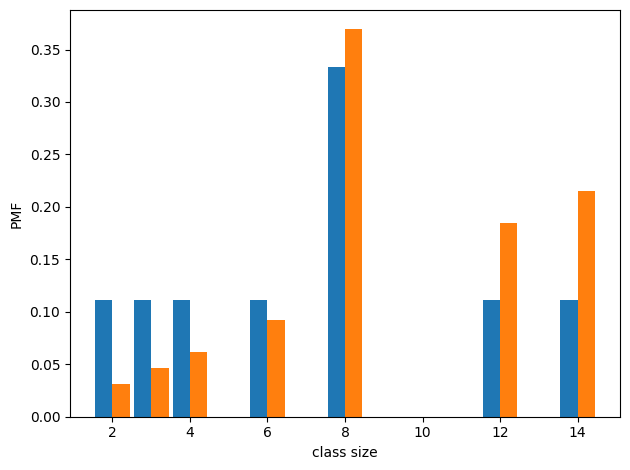

<IPython.core.display.Javascript object>

In [23]:
two_bar_plots(pmf, biased_pmf)
decorate(xlabel="class size", ylabel="PMF")

The following figure shows the result. In the biased distribution
there are fewer small classes and more large ones. The mean of the
biased distribution is 29.1, almost 25% higher than the actual mean.

It is also possible to invert this operation. Suppose you want to find
the distribution of class sizes at a college, but you can't get reliable
data from the Dean. An alternative is to choose a random sample of
students and ask how many students are in their classes.

The result would be biased for the reasons we've just seen, but you can
use it to estimate the actual distribution. Here's the function that
unbiases a `Pmf`:

In [24]:
def unbias_pmf(pmf, name):
    new_pmf = pmf.copy()
    new_pmf.name = name

    for x, p in pmf.items():
        new_pmf[x] /= x

    new_pmf.normalize()
    return new_pmf

<IPython.core.display.Javascript object>

It's similar to `unbias_pmf`; the only difference is that it divides each
probability by `x` instead of multiplying.

## `DataFrame` indexing

In Chapter 2 we read a pandas `DataFrame` and used it to select
and modify data columns. Now let's look at row selection. To start, I
create a NumPy array of random numbers and use it to initialize a
`DataFrame`:

In [25]:
array = np.random.random((4, 2))
df = pd.DataFrame(array)
df

,0,1
0,0.661852,0.441293
1,0.874123,0.691737
2,0.094712,0.943548
3,0.264337,0.120979


<IPython.core.display.Javascript object>

By default, the rows and columns are numbered starting at zero, but you
can provide column names:

In [26]:
columns = ["A", "B"]
df = pd.DataFrame(array, columns=columns)
df

,A,B
0,0.661852,0.441293
1,0.874123,0.691737
2,0.094712,0.943548
3,0.264337,0.120979


<IPython.core.display.Javascript object>

You can also provide row names. The set of row names is called the
**index**; the row names themselves are called **labels**.

In [27]:
index = ["a", "b", "c", "d"]
df = pd.DataFrame(array, columns=columns, index=index)
df

,A,B
a,0.661852,0.441293
b,0.874123,0.691737
c,0.094712,0.943548
d,0.264337,0.120979


<IPython.core.display.Javascript object>

As we saw in the previous chapter, simple indexing selects a column,
returning a `Series`:

In [28]:
df["A"]

a    0.661852
b    0.874123
c    0.094712
d    0.264337
Name: A, dtype: float64

<IPython.core.display.Javascript object>

To select a row by label, you can use the `loc` attribute, which returns
a `Series`:

In [29]:
df.loc["a"]

A    0.661852
B    0.441293
Name: a, dtype: float64

<IPython.core.display.Javascript object>

If you know the integer position of a row, rather than its label, you
can use the `iloc` attribute, which also returns a `Series`.

In [30]:
df.iloc[0]

A    0.661852
B    0.441293
Name: a, dtype: float64

<IPython.core.display.Javascript object>

`loc` can also take a list of labels; in that case, the result is a
`DataFrame`.

In [31]:
indices = ["a", "c"]
df.loc[indices]

,A,B
a,0.661852,0.441293
c,0.094712,0.943548


<IPython.core.display.Javascript object>

Finally, you can use a slice to select a range of rows by label:

In [32]:
df["a":"c"]

,A,B
a,0.661852,0.441293
b,0.874123,0.691737
c,0.094712,0.943548


<IPython.core.display.Javascript object>

Or by integer position:

In [33]:
df[0:2]

,A,B
a,0.661852,0.441293
b,0.874123,0.691737


<IPython.core.display.Javascript object>

The result in either case is a `DataFrame`, but notice that the first
result includes the end of the slice; the second doesn't.

My advice: if your rows have labels that are not simple integers, use
the labels consistently and avoid using integer positions.

## Glossary

-   **Probability mass function (PMF)**: a representation of a
    distribution as a function that maps from values to probabilities.

-   **probability**: A frequency expressed as a fraction of the sample
    size.

-   **normalization**: The process of dividing a frequency by a sample
    size to get a probability.

-   **index**: In a pandas `DataFrame`, the index is a special column that
    contains the row labels.

## Exercises

**Exercise:** In Section XXX we computed the mean of a sample by adding up
the elements and dividing by n.  If you are given a PMF, you can
still compute the mean, but the process is slightly different:

$$ \bar x = \sum_i p_i~x_i $$

where the $x_i$ are the unique values in the PMF and $p_i=PMF(x_i)$.
Similarly, you can compute variance like this:

$$ S^2 = \sum_i p_i~(x_i - \bar x)^2 $$
 
Write functions called `pmf_mean` and `pmf_var` that take a
`Pmf` object and compute the mean and variance.  To test these methods,
check that they are consistent with the methods `mean` and `var`
provided by `Pmf`.

In [34]:
pmf = Pmf.from_seq([1, 2, 2, 3, 5])
pmf.mean(), pmf.var()

(2.6, 1.84)

<IPython.core.display.Javascript object>

In [35]:
# Solution


def pmf_mean(pmf):
    """Computes the mean of a PMF.
    Returns:
        float mean
    """
    return sum(p * x for x, p in pmf.items())


pmf_mean(pmf)

2.6

<IPython.core.display.Javascript object>

In [36]:
# Solution


def pmf_var(pmf):
    """Computes the variance of a PMF.

    returns: float variance
    """
    mu = pmf_mean(pmf)
    return sum(p * (x - mu) ** 2 for x, p in pmf.items())


pmf_var(pmf)

1.84

<IPython.core.display.Javascript object>

**Exercise:** Something like the class size paradox appears if you survey children and ask how many children are in their family. Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

Use the NSFG respondent variable `numkdhh` to construct the actual distribution for the number of children under 18 in the respondents' households.

Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

In [37]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

<IPython.core.display.Javascript object>

In [38]:
resp = nsfg.read_fem_resp()

<IPython.core.display.Javascript object>

In [39]:
# Solution

pmf = Pmf.from_seq(resp.numkdhh, name="numkdhh")

<IPython.core.display.Javascript object>

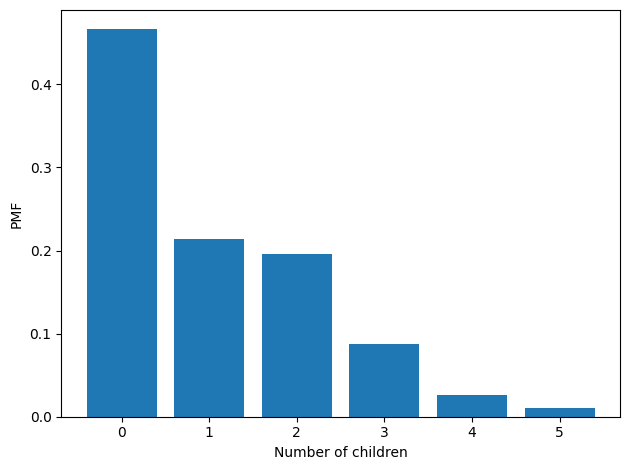

<IPython.core.display.Javascript object>

In [40]:
# Solution

pmf.bar()
decorate(xlabel="Number of children", ylabel="PMF")

In [41]:
# Solution

biased = bias_pmf(pmf, name="biased")

<IPython.core.display.Javascript object>

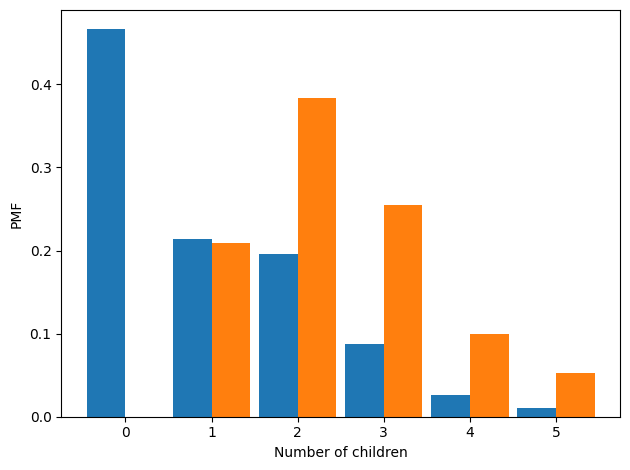

<IPython.core.display.Javascript object>

In [42]:
# Solution

two_bar_plots(pmf, biased)
decorate(xlabel="Number of children", ylabel="PMF")

In [43]:
# Solution

pmf.mean()

1.024205155043831

<IPython.core.display.Javascript object>

In [44]:
# Solution

biased.mean()

2.403679100664282

<IPython.core.display.Javascript object>

**Exercise:** I started this book with the question, "Are first babies more likely to be late?" To address it, I computed the difference in means between groups of babies, but I ignored the possibility that there might be a difference between first babies and others for the same woman.

To address this version of the question, select respondents who have at least two live births and compute pairwise differences. Does this formulation of the question yield a different result?

In [45]:
live, firsts, others = nsfg.make_frames()

<IPython.core.display.Javascript object>

In [46]:
preg_map = nsfg.make_preg_map(live)

<IPython.core.display.Javascript object>

In [47]:
# Solution

diffs = []
for caseid, indices in preg_map.items():
    if len(indices) >= 2:
        first, second = live.prglngth.loc[indices[0:2]]
        diff = first - second
        diffs.append(diff)

hist = Hist.from_seq(diffs, name="diffs")

<IPython.core.display.Javascript object>

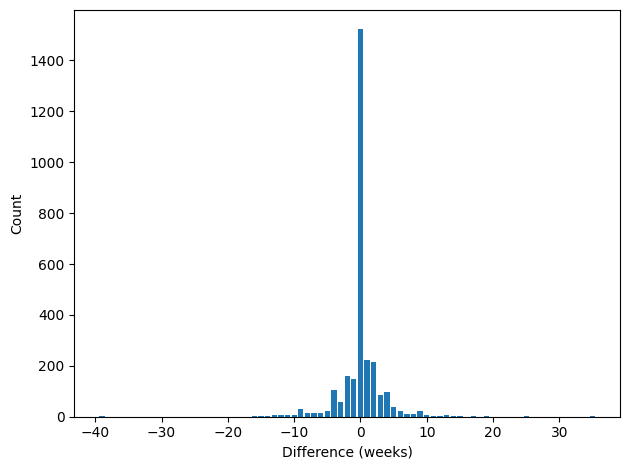

<IPython.core.display.Javascript object>

In [48]:
# Solution

hist.bar()
decorate(xlabel="Difference (weeks)", ylabel="Count")

In [49]:
# Solution

pmf = Pmf.from_seq(diffs)
pmf.mean()

0.0563674321503132

<IPython.core.display.Javascript object>

**Exercise:** In most foot races, everyone starts at the same time. If you are a fast runner, you usually pass a lot of people at the beginning of the race, but after a few miles everyone around you is going at the same speed.
When I ran a long-distance (209 miles) relay race for the first time, I noticed an odd phenomenon: when I overtook another runner, I was usually much faster, and when another runner overtook me, he was usually much faster.

At first I thought that the distribution of speeds might be bimodal; that is, there were many slow runners and many fast runners, but few at my speed.

Then I realized that I was the victim of a bias similar to the effect of class size. The race was unusual in two ways: it used a staggered start, so teams started at different times; also, many teams included runners at different levels of ability.

As a result, runners were spread out along the course with little relationship between speed and location. When I joined the race, the runners near me were (pretty much) a random sample of the runners in the race.

So where does the bias come from? During my time on the course, the chance of overtaking a runner, or being overtaken, is proportional to the difference in our speeds. I am more likely to catch a slow runner, and more likely to be caught by a fast runner. But runners at the same speed are unlikely to see each other.

Write a function called `ObservedPmf` that takes a `Pmf` representing the actual distribution of runners' speeds, and the speed of a running observer, and returns a new `Pmf` representing the distribution of runners' speeds as seen by the observer.

To test your function, you can use `relay.py`, which reads the results from the James Joyce Ramble 10K in Dedham, Massachusetts and converts the pace of each runner to mph.

Compute the distribution of speeds you would observe if you ran a relay race at 7 mph with this group of runners.

In [50]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/relay.py")
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/Apr25_27thAn_set1.shtml"
)

<IPython.core.display.Javascript object>

In [51]:
import relay

results = relay.read_results()
speeds = relay.get_speeds(results)
speeds = relay.bin_data(speeds, 3, 12, 100)

<IPython.core.display.Javascript object>

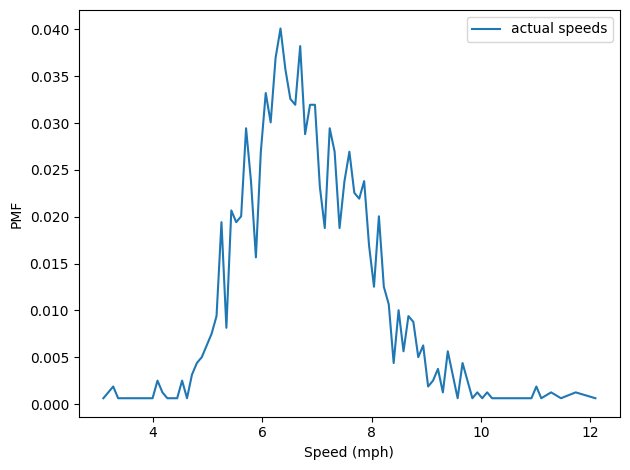

<IPython.core.display.Javascript object>

In [52]:
# Solution

pmf = Pmf.from_seq(speeds, name="actual speeds")
pmf.plot()
decorate(xlabel="Speed (mph)", ylabel="PMF")

In [53]:
# Solution


def observed_pmf(pmf, speed, name=None):
    """Returns a new Pmf representing speeds observed at a given speed.

    The chance of observing a runner is proportional to the difference
    in speed.

    Args:
        pmf: distribution of actual speeds
        speed: speed of the observing runner
        name: string name for the new dist

    Returns:
        Pmf object
    """
    new = pmf.copy()
    new.name = name

    for val, prob in new.items():
        diff = abs(val - speed)
        new[val] *= diff

    new.normalize()
    return new

<IPython.core.display.Javascript object>

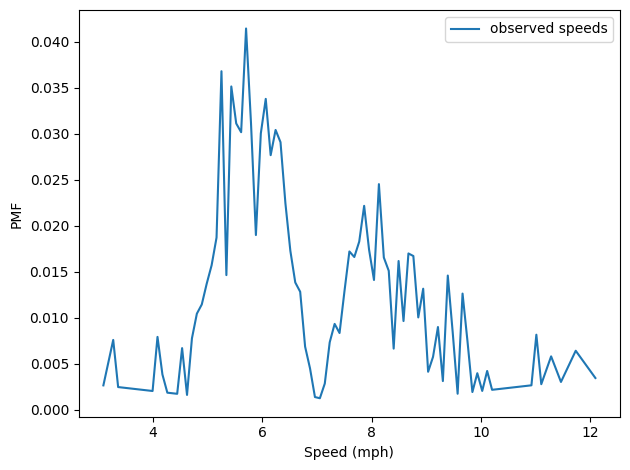

<IPython.core.display.Javascript object>

In [54]:
# Solution

biased = observed_pmf(pmf, 7, name="observed speeds")
biased.plot()
decorate(xlabel="Speed (mph)", ylabel="PMF")